<a href="https://colab.research.google.com/github/ramajoballester/mil_deeplearning/blob/main/3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enlaces de interés:
- [Dalle-mini](https://www.craiyon.com/)
- [DotCSV GPT-3](https://www.youtube.com/watch?v=C1eOiOkD_8A)
- [GPT-3](https://gpt3demo.com/apps/openai-gpt-3-playground)
- Experimento Big Science
 - [Supercomputador Jean Zay](http://www.idris.fr/eng/jean-zay/cpu/jean-zay-cpu-hw-eng.html)
 - [Tensorboard logs](https://huggingface.co/bigscience/tr11-176B-ml-logs/tensorboard?scroll=1#scalars&tagFilter=loss&_smoothingWeight=0)
 - [Gaugan 2](http://gaugan.org/gaugan2/)
 - GitHub Copilot



# Sesión 3. Redes Neuronales Recurrentes

In [ ]:
!pip install --upgrade -q gspread

In [ ]:
import gspread
from google.colab import auth
auth.authenticate_user()
from google.auth import default

In [ ]:
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
url = #
worksheet = gc.open_by_url(url)
row = 4

In [ ]:
col = 3
value = 'X'
worksheet.get_worksheet(2).update_cell(row, col, value);

# Sentiment Analysis

In [ ]:
! pip install -q torchtext torchdata torchmetrics torchsummary kaggle wandb

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d kazanova/sentiment140
! unzip sentiment140.zip

In [ ]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import torchmetrics
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
from torchsummary import summary
import math
import wandb

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def get_data():
    reader =  csv.reader(open("./training.1600000.processed.noemoticon.csv", "rt", encoding="latin-1"))
    data = []
    for each_line in reader:
        data.append((each_line[-1], int(each_line[0] == '4')))
        
    return data

In [ ]:
# data es una lista de tuplas (tweet [str], valor [int])
data = get_data()
# El tokenizador separa las oraciones en secuencias de palabras
tokenizer = torchtext.data.get_tokenizer('basic_english')
# Convertir a minúsculas y eliminar marcas de puntuación
data_list = [(' '.join(token for token in tokenizer(each[0].lower()) \
                       if token not in punctuation), each[1]) for each in data]

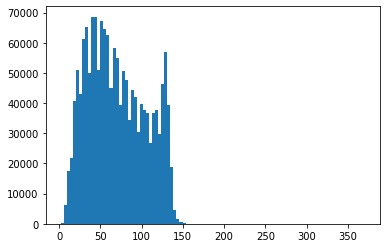

In [ ]:
# Histograma por longitud de tweet
x = [len(each[0]) for each in data_list]
plot = plt.hist(x, bins=100)

In [ ]:
(torch.Tensor(x) > 140).sum()

tensor(4777)

In [ ]:
# Cargamos la herramienta GloVe para crear los embeddings de las palabras
glove = torchtext.vocab.GloVe(name="6B", dim=50)

.vector_cache/glove.6B.zip: 862MB [02:52, 4.99MB/s]                           
100%|█████████▉| 399999/400000 [00:08<00:00, 45970.43it/s]


In [ ]:
# Frecuencia mínima para aparecer en el vocabulario
min_freq = 10
# Contador para repeticiones de palabras
counter = Counter()
# specials = ['<unk>', '<BOS>', '<EOS>', '<PAD>']
specials = ['<unk>', '<PAD>']
for each in specials:
    counter.update([each])
    counter[each] = min_freq
for (line, label) in data_list:
    counter.update(tokenizer(line))
vocab = torchtext.vocab.vocab(dict(counter), min_freq=min_freq)
# Índice para tokens OOV (Out Of Vocabulary)
vocab.set_default_index(0)

In [ ]:
# Transformación de palabras en números enteros (tokens)
text_transform = lambda x: [vocab[token] for token in tokenizer(x)]
data_preprocessed = [(torch.tensor(text_transform(each[0])),
                      torch.tensor(each[1])) \
                     for each in data_list]

In [ ]:
# Original
print(data[80000])
# Texto normalizado
print(data_list[80000])
# Texto tokenizado (int)
print(data_preprocessed[80000])

('Cannot actually keep my eyes open.., I feel like shit ', 0)
('cannot actually keep my eyes open i feel like shit', 0)
(tensor([2510,  606,  809,   55,  239, 1529,   42,  285,   60,  981]), tensor(0))


In [ ]:
random.seed(8080)
random.shuffle(data_preprocessed)
data_length = len(data_preprocessed)
train_list, test_list = torch.utils.data.random_split(data_preprocessed, 
                              [int(data_length*0.75),
                              int(data_length*0.25)], 
                              generator=torch.manual_seed(4040))
# train_list, test_list, _ = torch.utils.data.random_split(data_preprocessed, 
#                               [10000, 5000, int(len(data_preprocessed)-15000)], 
#                               generator=torch.manual_seed(4040))

## Redes Neuronales Recurrentes (RNN)

![rnn[1].svg]()

In [ ]:
len(vocab)

44990

In [ ]:
# Función de activación sigmoide no es necesaria con loss=BCEWithLogitsLoss
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # self.emb = nn.Embedding.from_pretrained(glove.vectors, freeze=True)
        self.emb = nn.Embedding(45000, 50)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Convertir en embedding
        x = self.emb(x)
        # Propagación hacia adelante RNN
        out, last_hidden = self.rnn(x)
        # Salida hacia la capa lineal
        out = self.fc(out[:, -1, :])
        # out = self.sigmoid(out)
        return out

In [ ]:
# Padding a las oraciones hasta la secuencia más larga
def collate_batch(batch):
    x, y = map(list, zip(*batch))
    return torch.nn.utils.rnn.pad_sequence(x, padding_value=3, batch_first=True), torch.tensor(y)

In [ ]:
# Extracción de muestras de un pool the longitudes similares
def batch_sampler(data_list):
    indices = [(i, len(s[0])) for i, s in enumerate(data_list)]
    random.shuffle(indices)
    pooled_indices = []
    # Crear un pool de batch_size*100 índices con longitudes similares
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(sorted(indices[i:i + batch_size * 100], key=lambda x: x[1]))

    pooled_indices = [x[0] for x in pooled_indices]

    # Devolver índices del batch actual
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i:i + batch_size]

In [ ]:
def train(model, dataloader, device, optimizer, loss_fn):
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds.squeeze(1), y.float())
        loss.backward()
        optimizer.step()

In [ ]:
def test(model, dataloader, device, loss_fn, metrics_fn=None):
    loss_total = 0.0
    model.eval()
    metrics_fn.reset()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = loss_fn(preds.squeeze(1), y.float())
            metrics = metrics_fn(torch.sigmoid(preds.squeeze(1)), y)
            loss_total += loss.sum()
        metrics = metrics_fn.compute()
    return loss_total, metrics

In [ ]:
input_size = 50
hidden_size = 60
n_classes = 1
batch_size = 1024
lr = 0.002
num_epochs = 10

train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
test_dataloader = torch.utils.data.DataLoader(test_list, batch_sampler=batch_sampler(test_list),
                               collate_fn=collate_batch)

# Modelo
model = RNNModel(input_size=input_size,
            hidden_size=hidden_size,
            num_classes=n_classes).to(device)

# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss().to(device)
# loss_fn = nn.BCELoss().to(device)
metrics_fn = torchmetrics.Accuracy().to(device)


config = {
  "learning_rate":lr,
  "epochs": num_epochs,
  "batch_size": batch_size,
  'optimizer': optimizer.__class__.__name__
}

wandb.init(project="Sesión 3", name='RNN', config=config)

train_len = len(train_list)
test_len = len(test_list)
best_metrics = 0

for epoch in range(num_epochs):
    # Entrenamiento
    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train(model, train_dataloader, device, optimizer, loss_fn)

    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train_loss, train_metrics = test(model, train_dataloader, device, loss_fn, metrics_fn)
    wandb.log({"Train loss": train_loss/train_len}, step=epoch)
    wandb.log({"Train accuracy": train_metrics}, step=epoch)

    print('\nEpoch {}'.format(epoch))
    print('Training Loss: {:.6f}, Training Accuracy: {:.2f}%'.format(train_loss/train_len, train_metrics*100))

    # Evaluación
    test_dataloader = torch.utils.data.DataLoader(test_list, batch_sampler=batch_sampler(test_list),
                               collate_fn=collate_batch)
    test_loss, test_metrics = test(model, test_dataloader, device, loss_fn, metrics_fn)
    wandb.log({"Test loss": test_loss/test_len}, step=epoch)
    wandb.log({"Test accuracy": test_metrics}, step=epoch)

    print('Test Loss: {:.6f}, Test Accuracy: {:.2f}%'.format(test_loss/test_len, test_metrics*100))

    if test_metrics > best_metrics:
        best_metrics = test_metrics

    # Subir resultados a GS
    col = 4
    value = best_metrics
    worksheet.get_worksheet(2).update_cell(row, col, float(value));

wandb.finish()

## Gated-Recurrent Units (GRU)

![gru-3[1].svg]()

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # self.emb = nn.Embedding.from_pretrained(glove.vectors, freeze=False)
        self.emb = nn.Embedding(45000, 50)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
#         self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Convertir en embedding
        x = self.emb(x)
        # Propagación hacia adelante RNN
        out, last_hidden = self.gru(x)
        # Salida hacia la capa lineal
        out = self.fc(out[:, -1, :])
#         out = self.sigmoid(out)
        return out

In [ ]:
input_size = 50
hidden_size = 60
n_classes = 1
batch_size = 1024
lr = 0.001
num_epochs = 5

train_dataloader = torch.utils.data.DataLoader(train_list, collate_fn=collate_batch,
                                               batch_sampler=batch_sampler(train_list))
test_dataloader = torch.utils.data.DataLoader(test_list, collate_fn=collate_batch,
                                              batch_sampler=batch_sampler(test_list))
# Modelo
model = GRUModel(input_size=input_size,
            hidden_size=hidden_size,
            num_classes=n_classes).to(device)

# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss().to(device)
# loss_fn = nn.BCELoss().to(device)
metrics_fn = torchmetrics.Accuracy().to(device)

num_epochs = 5

config = {
  "learning_rate":lr,
  "epochs": num_epochs,
  "batch_size": batch_size,
  'optimizer': optimizer.__class__.__name__
}

wandb.init(project="Sesión 3", name='GRU', config=config)

train_len = len(train_list)
test_len = len(test_list)
best_metrics = 0

for epoch in range(num_epochs):
    # Entrenamiento
    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train(model, train_dataloader, device, optimizer, loss_fn)

    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train_loss, train_metrics = test(model, train_dataloader, device, loss_fn, metrics_fn)
    wandb.log({"Train loss": train_loss/train_len}, step=epoch)
    wandb.log({"Train accuracy": train_metrics}, step=epoch)

    print('\nEpoch {}'.format(epoch))
    print('Training Loss: {:.6f}, Training Accuracy: {:.2f}%'.format(train_loss/train_len, train_metrics*100))

    # Evaluación
    test_dataloader = torch.utils.data.DataLoader(test_list, batch_sampler=batch_sampler(test_list),
                               collate_fn=collate_batch)
    test_loss, test_metrics = test(model, test_dataloader, device, loss_fn, metrics_fn)
    wandb.log({"Test loss": test_loss/test_len}, step=epoch)
    wandb.log({"Test accuracy": test_metrics}, step=epoch)

    print('Test Loss: {:.6f}, Test Accuracy: {:.2f}%'.format(test_loss/test_len, test_metrics*100))

    if test_metrics > best_metrics:
        best_metrics = test_metrics

    col = 5
    value = best_metrics
    worksheet.get_worksheet(2).update_cell(row, col, float(value));

wandb.finish()

Test accuracy,█▆▁
Test loss,▁▄█
Train accuracy,█▆▁
Train loss,▁▄█
Test accuracy,0.69112
Test loss,0.00057
Train accuracy,0.69781
Train loss,0.00056



Epoch 0
Training Loss: 0.000443, Training Accuracy: 79.25%
Test Loss: 0.000448, Test Accuracy: 78.82%

Epoch 1
Training Loss: 0.000393, Training Accuracy: 81.72%
Test Loss: 0.000407, Test Accuracy: 80.83%

Epoch 2
Training Loss: 0.000372, Training Accuracy: 82.95%
Test Loss: 0.000391, Test Accuracy: 81.78%

Epoch 3
Training Loss: 0.000357, Training Accuracy: 83.74%
Test Loss: 0.000384, Test Accuracy: 82.15%

Epoch 4
Training Loss: 0.000346, Training Accuracy: 84.33%
Test Loss: 0.000381, Test Accuracy: 82.37%


Test accuracy,▁▅▇██
Test loss,█▄▂▁▁
Train accuracy,▁▄▆▇█
Train loss,█▄▃▂▁
Test accuracy,0.82371
Test loss,0.00038
Train accuracy,0.84329
Train loss,0.00035


## Long Short-Term Memory (LSTM)

![lstm-3[1].svg]()

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # self.emb = nn.Embedding.from_pretrained(glove.vectors, freeze=False)
        self.emb = nn.Embedding(45000, 50)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Convertir en embedding
        x = self.emb(x)
        # Propagación hacia adelante RNN
        out, last_hidden = self.lstm(x)
        # Salida hacia la capa lineal
        out = self.fc(out[:, -1, :])
        # out = self.sigmoid(out)
        return out

In [ ]:
input_size = 50
hidden_size = 60
n_classes = 1
batch_size = 1024
lr = 0.001
num_epochs = 5

train_dataloader = torch.utils.data.DataLoader(train_list, collate_fn=collate_batch,
                                               batch_sampler=batch_sampler(train_list))
test_dataloader = torch.utils.data.DataLoader(test_list, collate_fn=collate_batch,
                                              batch_sampler=batch_sampler(test_list))
# Modelo
model = LSTMModel(input_size=input_size,
            hidden_size=hidden_size,
            num_classes=n_classes).to(device)

# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss().to(device)
# loss_fn = nn.BCELoss().to(device)
metrics_fn = torchmetrics.Accuracy().to(device)

num_epochs = 5

config = {
  "learning_rate":lr,
  "epochs": num_epochs,
  "batch_size": batch_size,
  'optimizer': optimizer.__class__.__name__
}

wandb.init(project="Sesión 3", name='LSTM', config=config)

train_len = len(train_list)
test_len = len(test_list)
best_metrics = 0

for epoch in range(num_epochs):
    # Entrenamiento
    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train(model, train_dataloader, device, optimizer, loss_fn)

    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train_loss, train_metrics = test(model, train_dataloader, device, loss_fn, metrics_fn)
    wandb.log({"Train loss": train_loss/train_len}, step=epoch)
    wandb.log({"Train accuracy": train_metrics}, step=epoch)

    print('\nEpoch {}'.format(epoch))
    print('Training Loss: {:.6f}, Training Accuracy: {:.2f}%'.format(train_loss/train_len, train_metrics*100))

    # Evaluación
    test_dataloader = torch.utils.data.DataLoader(test_list, batch_sampler=batch_sampler(test_list),
                               collate_fn=collate_batch)
    test_loss, test_metrics = test(model, test_dataloader, device, loss_fn, metrics_fn)
    wandb.log({"Test loss": test_loss/test_len}, step=epoch)
    wandb.log({"Test accuracy": test_metrics}, step=epoch)

    print('Test Loss: {:.6f}, Test Accuracy: {:.2f}%'.format(test_loss/test_len, test_metrics*100))

    if test_metrics > best_metrics:
        best_metrics = test_metrics

    col = 6
    value = best_metrics
    worksheet.get_worksheet(2).update_cell(row, col, float(value));

wandb.finish()


Epoch 0
Training Loss: 0.000435, Training Accuracy: 79.92%
Test Loss: 0.000443, Test Accuracy: 79.38%

Epoch 1
Training Loss: 0.000392, Training Accuracy: 82.05%
Test Loss: 0.000406, Test Accuracy: 81.14%

Epoch 2
Training Loss: 0.000372, Training Accuracy: 83.09%
Test Loss: 0.000392, Test Accuracy: 81.79%

Epoch 3
Training Loss: 0.000356, Training Accuracy: 83.83%
Test Loss: 0.000384, Test Accuracy: 82.18%

Epoch 4
Training Loss: 0.000347, Training Accuracy: 84.32%
Test Loss: 0.000382, Test Accuracy: 82.27%


Test accuracy,▁▅▇██
Test loss,█▄▂▁▁
Train accuracy,▁▄▆▇█
Train loss,█▅▃▂▁
Test accuracy,0.82267
Test loss,0.00038
Train accuracy,0.84322
Train loss,0.00035


In [ ]:
col = 6
value = best_metrics
worksheet.get_worksheet(2).update_cell(row, col, float(value));

## RNN profundas

![deep-rnn[1].svg]()

In [ ]:
class DeepRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super().__init__()
        # self.emb = nn.Embedding.from_pretrained(glove.vectors, freeze=False)
        self.emb = nn.Embedding(45000, 50)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
#         self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Convertir en embedding
        x = self.emb(x)
        # Propagación hacia adelante RNN
        out, last_hidden = self.rnn(x)
        # Salida hacia la capa lineal
        out = self.fc(out[:, -1, :])
#         out = self.sigmoid(out)
        return out

In [ ]:
input_size = 50
hidden_size = 60
n_classes = 1
num_layers = 3
batch_size = 1024
lr = 0.001

train_dataloader = torch.utils.data.DataLoader(train_list, collate_fn=collate_batch,
                                               batch_sampler=batch_sampler(train_list))
test_dataloader = torch.utils.data.DataLoader(test_list, collate_fn=collate_batch,
                                              batch_sampler=batch_sampler(test_list))
# Modelo
model = DeepRNNModel(input_size=input_size,
            hidden_size=hidden_size,
            num_classes=n_classes, 
            num_layers=num_layers).to(device)

# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss().to(device)
# loss_fn = nn.BCELoss().to(device)
metrics_fn = torchmetrics.Accuracy().to(device)

num_epochs = 5

config = {
  "learning_rate":lr,
  "epochs": num_epochs,
  "batch_size": batch_size,
  'optimizer': optimizer.__class__.__name__
}

wandb.init(project="Sesión 3", name='Deep RNN', config=config)

train_len = len(train_list)
test_len = len(test_list)
best_metrics = 0

for epoch in range(num_epochs):
    # Entrenamiento
    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train(model, train_dataloader, device, optimizer, loss_fn)

    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train_loss, train_metrics = test(model, train_dataloader, device, loss_fn, metrics_fn)
    wandb.log({"Train loss": train_loss/train_len}, step=epoch)
    wandb.log({"Train accuracy": train_metrics}, step=epoch)

    print('\nEpoch {}'.format(epoch))
    print('Training Loss: {:.6f}, Training Accuracy: {:.2f}%'.format(train_loss/train_len, train_metrics*100))

    # Evaluación
    test_dataloader = torch.utils.data.DataLoader(test_list, batch_sampler=batch_sampler(test_list),
                               collate_fn=collate_batch)
    test_loss, test_metrics = test(model, test_dataloader, device, loss_fn, metrics_fn)
    wandb.log({"Test loss": test_loss/test_len}, step=epoch)
    wandb.log({"Test accuracy": test_metrics}, step=epoch)

    print('Test Loss: {:.6f}, Test Accuracy: {:.2f}%'.format(test_loss/test_len, test_metrics*100))

    if test_metrics > best_metrics:
        best_metrics = test_metrics

    col = 7
    value = best_metrics
    worksheet.get_worksheet(2).update_cell(row, col, float(value));

wandb.finish()


Epoch 0
Training Loss: 0.000577, Training Accuracy: 64.69%
Test Loss: 0.000582, Test Accuracy: 64.54%

Epoch 1
Training Loss: 0.000426, Training Accuracy: 80.37%
Test Loss: 0.000437, Test Accuracy: 79.62%

Epoch 2
Training Loss: 0.000422, Training Accuracy: 80.19%
Test Loss: 0.000440, Test Accuracy: 79.29%

Epoch 3
Training Loss: 0.000391, Training Accuracy: 81.97%
Test Loss: 0.000412, Test Accuracy: 80.71%

Epoch 4
Training Loss: 0.000381, Training Accuracy: 82.79%
Test Loss: 0.000403, Test Accuracy: 81.28%


Test accuracy,▁▇▇██
Test loss,█▂▂▁▁
Train accuracy,▁▇▇██
Train loss,█▃▂▁▁
Test accuracy,0.81283
Test loss,0.0004
Train accuracy,0.82788
Train loss,0.00038


## RNN Bidireccionales

![birnn[1].svg]()

In [ ]:
class BRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super().__init__()
        # self.emb = nn.Embedding.from_pretrained(glove.vectors, freeze=False)
        self.emb = nn.Embedding(45000, 50)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        # self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Convertir en embedding
        x = self.emb(x)
        # Propagación hacia adelante RNN
        out, last_hidden = self.rnn(x)
        # Salida hacia la capa lineal
        out = self.fc(out[:, -1, :])
        # out = self.sigmoid(out)
        return out

In [ ]:
input_size = 50
hidden_size = 60
n_classes = 1
num_layers = 1
batch_size = 1024
lr = 0.001

train_dataloader = torch.utils.data.DataLoader(train_list, collate_fn=collate_batch,
                                               batch_sampler=batch_sampler(train_list))
test_dataloader = torch.utils.data.DataLoader(test_list, collate_fn=collate_batch,
                                              batch_sampler=batch_sampler(test_list))
# Modelo
model = BRNNModel(input_size=input_size,
            hidden_size=hidden_size,
            num_classes=n_classes, 
            num_layers=num_layers).to(device)

# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss().to(device)
# loss_fn = nn.BCELoss().to(device)
metrics_fn = torchmetrics.Accuracy().to(device)

num_epochs = 5

config = {
  "learning_rate":lr,
  "epochs": num_epochs,
  "batch_size": batch_size,
  'optimizer': optimizer.__class__.__name__
}

wandb.init(project="Sesión 3", name='Bidireccional RNN', config=config)

train_len = len(train_list)
test_len = len(test_list)
best_metrics = 0

for epoch in range(num_epochs):
    # Entrenamiento
    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train(model, train_dataloader, device, optimizer, loss_fn)

    train_dataloader = torch.utils.data.DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                               collate_fn=collate_batch)
    train_loss, train_metrics = test(model, train_dataloader, device, loss_fn, metrics_fn)
    wandb.log({"Train loss": train_loss/train_len}, step=epoch)
    wandb.log({"Train accuracy": train_metrics}, step=epoch)

    print('\nEpoch {}'.format(epoch))
    print('Training Loss: {:.6f}, Training Accuracy: {:.2f}%'.format(train_loss/train_len, train_metrics*100))

    # Evaluación
    test_dataloader = torch.utils.data.DataLoader(test_list, batch_sampler=batch_sampler(test_list),
                               collate_fn=collate_batch)
    test_loss, test_metrics = test(model, test_dataloader, device, loss_fn, metrics_fn)
    wandb.log({"Test loss": test_loss/test_len}, step=epoch)
    wandb.log({"Test accuracy": test_metrics}, step=epoch)

    print('Test Loss: {:.6f}, Test Accuracy: {:.2f}%'.format(test_loss/test_len, test_metrics*100))

    if test_metrics > best_metrics:
        best_metrics = test_metrics

    col = 8
    value = best_metrics
    worksheet.get_worksheet(2).update_cell(row, col, float(value));

wandb.finish()


Epoch 0
Training Loss: 0.000448, Training Accuracy: 79.57%
Test Loss: 0.000456, Test Accuracy: 78.94%

Epoch 1
Training Loss: 0.000437, Training Accuracy: 79.97%
Test Loss: 0.000450, Test Accuracy: 78.95%

Epoch 2
Training Loss: 0.000412, Training Accuracy: 81.36%
Test Loss: 0.000430, Test Accuracy: 80.15%

Epoch 3
Training Loss: 0.000397, Training Accuracy: 81.94%
Test Loss: 0.000417, Test Accuracy: 80.61%

Epoch 4
Training Loss: 0.000388, Training Accuracy: 82.53%
Test Loss: 0.000412, Test Accuracy: 80.96%


Test accuracy,▁▁▅▇█
Test loss,█▇▄▂▁
Train accuracy,▁▂▅▇█
Train loss,█▇▄▂▁
Test accuracy,0.80965
Test loss,0.00041
Train accuracy,0.8253
Train loss,0.00039


## Transformers

Modelos autoregresivos

In [ ]:
train_dataloader, val_dataloader, test_dataloader = torchtext.datasets.WikiText2(root='data')

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()

        # max_len define la posición (distancia) máxima que tiene efecto
        # en un token
        
        # Dropout
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - A partir de la fórmula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Buffer: se guardan los parámetros en el modelo pero no se entrenan
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Conexión residual y encoding posicional
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [ ]:
class Transformer(nn.Module):
    # Constructor
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers,
                 num_decoder_layers, dropout_p):
        super().__init__()

        self.model_type = "Transformer"
        self.dim_model = dim_model
        glove = torchtext.vocab.GloVe(name="6B", dim=dim_model)

        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=700
        )

        # self.embedding = nn.Embedding(num_tokens, dim_model)
        self.embedding = nn.Embedding.from_pretrained(glove.vectors, freeze=True)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):

        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:

        mask = torch.tril(torch.ones(size, size) == 1) 
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) 
        mask = mask.masked_fill(mask == 1, float(0.0)) 
        
        # Ejemplo para tamaño fijo:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)

In [ ]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    np.random.shuffle(data)

    return data


def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            # Here you would need to get the max length of the batch,
            # and normalize the length with the PAD token.
            if padding:
                max_batch_length = 0

                # Get longest sentence in batch
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # Append X padding tokens until it reaches the max length
                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

562 batches of size 16
187 batches of size 16


In [ ]:
train_iter = iter(train_dataloader)

In [ ]:
next(train_iter).shape

(16, 2, 10)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(num_tokens=4, dim_model=8, num_heads=2,
                    num_encoder_layers=3, num_decoder_layers=3,
                    dropout_p=0.1).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train_loop(model, opt, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.train()
    total_loss = 0

    i = 0

    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        # X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)
        X, y = X.to(device), y.to(device)

        print(i)
        i += 1

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [ ]:
def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            # X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)
            X, y = X.to(device), y.to(device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [ ]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list

In [ ]:
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)

Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.6124
Validation loss: 0.4144

------------------------- Epoch 2 -------------------------
Training loss: 0.4211
Validation loss: 0.3873

------------------------- Epoch 3 -------------------------
Training loss: 0.3983
Validation loss: 0.3666

------------------------- Epoch 4 -------------------------
Training loss: 0.3772
Validation loss: 0.3381

------------------------- Epoch 5 -------------------------
Training loss: 0.3543
Validation loss: 0.3010

------------------------- Epoch 6 -------------------------
Training loss: 0.3305
Validation loss: 0.2680

------------------------- Epoch 7 -------------------------
Training loss: 0.3054
Validation loss: 0.2348

------------------------- Epoch 8 -------------------------
Training loss: 0.2831
Validation loss: 0.2096

------------------------- Epoch 9 -------------------------
Training loss: 0.2667
Validation loss: 0.2009

-------

## Procesamiento del Lenguaje Natural (NLP)

In [ ]:
train_dataset, val_dataset, test_dataset = torchtext.datasets.WikiText2(root='alvaro/data')

In [ ]:
train_data = np.array([item for item in train_dataset])
test_data = np.array([item for item in test_dataset])

In [ ]:
len(train_data)

36718

In [ ]:
train_data = np.delete(train_data, train_data == ' \n')
test_data = np.delete(test_data, test_data == ' \n')

In [ ]:
len(train_data)

23767

In [ ]:
train_data[2000]

' Few biological or medical applications exist for antimony . <unk> principally containing antimony are known as <unk> and are used as <unk> . Antimony compounds are used as <unk> drugs . <unk> <unk> tartrate , or tartar emetic , was once used as an anti @-@ <unk> drug from 1919 on . It was subsequently replaced by <unk> . Antimony and its compounds are used in several <unk> preparations like <unk> or lithium antimony <unk> , which is used as a skin <unk> in <unk> . Antimony has a nourishing or conditioning effect on <unk> tissues , at least in animals . \n'

In [ ]:
# El tokenizador separa las oraciones en secuencias de palabras
tokenizer = torchtext.data.get_tokenizer('basic_english')
# Convertir a minúsculas y eliminar marcas de puntuación
train_preprocessed = ['<sos> '+(' '.join(token for token in tokenizer(each.lower()) \
                       if token not in punctuation))+' <eos>' for each in train_data]
test_preprocessed = ['<sos> '+(' '.join(token for token in tokenizer(each.lower()) \
                       if token not in punctuation))+' <eos>' for each in test_data]

In [ ]:
train_preprocessed[2000]

'<sos> few biological or medical applications exist for antimony <unk> principally containing antimony are known as <unk> and are used as <unk> antimony compounds are used as <unk> drugs <unk> <unk> tartrate or tartar emetic was once used as an anti @-@ <unk> drug from 1919 on it was subsequently replaced by <unk> antimony and its compounds are used in several <unk> preparations like <unk> or lithium antimony <unk> which is used as a skin <unk> in <unk> antimony has a nourishing or conditioning effect on <unk> tissues at least in animals <eos>'

In [ ]:
# Frecuencia mínima para aparecer en el vocabulario
min_freq = 20
# Contador para repeticiones de palabras
counter = Counter()
specials = ['<unk>', '<sos>', '<eos>', '<pad>']
# specials = ['<unk>', '<PAD>']
for each in specials:
    counter.update([each])
    counter[each] = min_freq
for line in train_preprocessed:
    counter.update(tokenizer(line))
vocab = torchtext.vocab.vocab(dict(counter), min_freq=min_freq)
# Índice para tokens OOV (Out Of Vocabulary)
vocab.set_default_index(0)

In [ ]:
vocab.get_stoi()['<sos>']

1

In [ ]:
counter['<sos>']

23787

In [ ]:
len(vocab)

8113

[GloVe](https://nlp.stanford.edu/projects/glove/)

In [ ]:
# Transformación de palabras en números enteros (tokens)
glove = torchtext.vocab.GloVe(name="6B", dim=50)
text_transform = lambda x: torch.Tensor([vocab[token] for token in tokenizer(x)]).to(torch.long)
train_tokenized = [text_transform(each) for each in train_preprocessed]
test_tokenized = [text_transform(each) for each in test_preprocessed]

In [ ]:
train_lengths = [len(each) for each in train_tokenized]

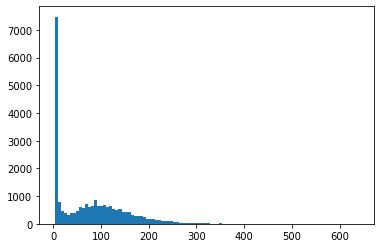

In [ ]:
plt.hist(train_lengths, bins=100);

In [ ]:
print(train_data[2000])
print(train_preprocessed[2000])
print(train_tokenized[2000])

 Few biological or medical applications exist for antimony . <unk> principally containing antimony are known as <unk> and are used as <unk> . Antimony compounds are used as <unk> drugs . <unk> <unk> tartrate , or tartar emetic , was once used as an anti @-@ <unk> drug from 1919 on . It was subsequently replaced by <unk> . Antimony and its compounds are used in several <unk> preparations like <unk> or lithium antimony <unk> , which is used as a skin <unk> in <unk> . Antimony has a nourishing or conditioning effect on <unk> tissues , at least in animals . 

<sos> few biological or medical applications exist for antimony <unk> principally containing antimony are known as <unk> and are used as <unk> antimony compounds are used as <unk> drugs <unk> <unk> tartrate or tartar emetic was once used as an anti @-@ <unk> drug from 1919 on it was subsequently replaced by <unk> antimony and its compounds are used in several <unk> preparations like <unk> or lithium antimony <unk> which is used as a s

In [ ]:
vocab.get_itos()[6491]

'biological'

In [ ]:
len(glove)

400000

### Entrenamiento

In [ ]:
batch_size = 16
lr = 0.01

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(num_tokens=len(vocab), dim_model=50, num_heads=2,
                    num_encoder_layers=3, num_decoder_layers=3,
                    dropout_p=0.1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
# metrics_fn = torchmetrics.Accuracy().to(device)

In [ ]:
trainable_param = 0
nontrainable_param = 0
for param in model.parameters():
    if param.requires_grad:
        trainable_param += param.numel()
    else:
        nontrainable_param += param.numel()

print('Parámetros entrenables: {}'.format(trainable_param))
print('Parámetros no entrenables: {}'.format(nontrainable_param))

Parámetros entrenables: 1748651
Parámetros no entrenables: 20000000


In [ ]:
# Padding a las oraciones hasta la secuencia más larga
def collate_batch(batch):
    tmp = torch.nn.utils.rnn.pad_sequence(batch, padding_value=3, batch_first=True)
    return torch.stack([tmp, tmp]).permute(1, 0, 2)

In [ ]:
# Extracción de muestras de un pool the longitudes similares
def batch_sampler(data_list):
    indices = [(i, len(s)) for i, s in enumerate(data_list)]
    random.shuffle(indices)
    pooled_indices = []
    # Crear un pool de batch_size*100 índices con longitudes similares
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(sorted(indices[i:i + batch_size * 100], key=lambda x: x[1]))

    pooled_indices = [x[0] for x in pooled_indices]

    # Devolver índices del batch actual
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i:i + batch_size]

In [ ]:
def train(model, dataloader, device, optimizer, loss_fn):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = X.to(device), y.to(device)

        # Desplazamos a la izquierda el target para predecir con el <sos> 
        # la primera palabra
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Máscara para eliminar las siguientes palabras de cada línea
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Forward pass
        pred = model(X, y_input, tgt_mask)

        # Permutar para tener el batch_size como primer canal
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        # Propagación hacia atrás
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        total_loss += loss.detach().item()
        
    return total_loss

In [ ]:
def test(model, dataloader, device, loss_fn, metrics_fn=None):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = X.to(device), y.to(device)

            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)
            pred = model(X, y_input, tgt_mask)

            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            if metrics_fn:
                metrics = metrics_fn(torch.softmax(pred, dim=-1), y_expected)
            total_loss += loss.detach().item()
        if metrics_fn:
            metrics = metrics_fn.compute()
        
    return total_loss

In [ ]:
train_len = len(train_tokenized)
test_len = len(test_tokenized)

for epoch in range(25):
    t1 = time.time()
    train_dataloader = torch.utils.data.DataLoader(train_tokenized,
                                                   batch_sampler=batch_sampler(train_tokenized),
                                                   collate_fn=collate_batch)
    train_loss = train(model, train_dataloader, device, optimizer, loss_fn)
    t2 = time.time()
    test_dataloader = torch.utils.data.DataLoader(test_tokenized,
                                                   batch_sampler=batch_sampler(test_tokenized),
                                                   collate_fn=collate_batch)
    test_loss = test(model, test_dataloader, device, loss_fn)
    t3 = time.time()
    print('\nEpoch {}'.format(epoch))
    print('Training Loss: {:.4f}, test loss: {:.4f}, training time {:.2f}'.format(train_loss / train_len,
                                                                                  test_loss / test_len,
                                                                                  t2-t1))


Epoch 0
Training Loss: 0.4045, test loss: 0.3871, training time 49.44

Epoch 1
Training Loss: 0.3841, test loss: 0.3735, training time 49.08

Epoch 2
Training Loss: 0.3714, test loss: 0.3571, training time 50.14

Epoch 3
Training Loss: 0.3630, test loss: 0.3433, training time 49.59

Epoch 4
Training Loss: 0.3568, test loss: 0.3346, training time 49.65

Epoch 5
Training Loss: 0.3517, test loss: 0.3280, training time 50.12

Epoch 6
Training Loss: 0.3478, test loss: 0.3251, training time 50.16

Epoch 7
Training Loss: 0.3444, test loss: 0.3202, training time 50.09

Epoch 8
Training Loss: 0.3415, test loss: 0.3169, training time 50.32

Epoch 9
Training Loss: 0.3386, test loss: 0.3153, training time 50.13

Epoch 10
Training Loss: 0.3361, test loss: 0.3119, training time 50.04

Epoch 11
Training Loss: 0.3339, test loss: 0.3108, training time 49.83

Epoch 12
Training Loss: 0.3321, test loss: 0.3070, training time 49.82

Epoch 13
Training Loss: 0.3301, test loss: 0.3062, training time 49.58

E

### Inferencia

In [ ]:
def predict(model, input_sequence, device, max_length=100, SOS_token=1, EOS_token=2):
    model.eval()
    y_input = input_sequence
    num_tokens = len(input_sequence)

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()

In [ ]:
idx = 2005
test_preprocessed[idx][:83]

'<sos> in 422 augustine of <unk> wrote about 2 <unk> 2 1 – 11 where he believed paul'

In [ ]:
input_text = text_transform(test_preprocessed[idx][:83]).to(device)
input_text

tensor([   1,   37,    0,    0,   11,    0, 1573,  583, 1118,    0, 1118,  788,
        1397, 1307,  147,  406, 2288, 2501], device='cuda:0')

In [ ]:
pred = predict(model, input_text.unsqueeze(0), device)
pred_text = [vocab.get_itos()[each] for each in pred]
' '.join(pred_text)

'<sos> in <unk> <unk> of <unk> wrote about 2 <unk> 2 1 – 11 where he believed paul <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> – <unk> – <unk> – <unk> <unk> – <unk> – <unk> – <unk> – <unk> – <unk> – <unk> <unk> – <unk> – <unk> – <unk> – <unk> <eos>'